## 1. Data preparation and cleaning 🧹

Before training any model, we need to prepare the dataset properly.
The raw data consists of historical matches between **Chelsea** and **Liverpool**, between 1921 and 2025, including match date and the number of goals scored.

Steps in this section:
- **Load the dataset** (from CSV export of oGol: https://www.ogol.com.br/estatisticas/chelsea-liverpool/t81-t85?id_comp=0&grp=1&epoca_ini=0&page=1).
- **Select relevant columns**:
- `date` → independent variable \(x\) (converted into numerical format yyyyMMdd (yearmonthday) since the first recorded match).
- `goals_total` → dependent variable \(y\) (sum of Chelsea and Liverpool goals grouped by year).
- **Convert dates** into a numeric scale suitable for regression, group date by year.
- **Visual sanity check**: print dataset head, plot goals over time, and check for anomalies (outliers, wrong entries, etc.).

⚠️ *Note*: Using date as the only predictor is a simplification — the intent is to build a clean, minimal dataset for a first regression experiment.

### 1.1 Load the dataset 📂

We start by loading the dataset from the `data/All_Games_Chelsea_Vs_Liverpool.csv` file.  
The file contains historical matches, with columns for date, result, teams, and score.  

Steps in this subsection:

- Import libraries (`pandas`, `numpy`, `matplotlib`).
- Load the CSV file into a DataFrame.
- Inspect the dataset (`head()`, `info()`) to verify the structure.
- Parse the **Date** column as `datetime`.
- Split the **Score** column into numerical values (goals for each team).
- Create a new column `goals_total` = sum of Chelsea and Liverpool goals.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = "../data/All_Games_Chelsea_Vs_Liverpool.csv"

# Read as pipe-delimited, skip the inconsistent header line, and define proper column names
df = pd.read_csv(
    file_path,
    sep=r"\|",
    engine="python",
    header=None,
    skiprows=1,  # skip the first row "ChelseaResult|DateTime1|Score|Time2"
    names=["ChelseaResult", "Date", "Time1", "Score", "Time2"],
    dtype=str
)

# Strip leading/trailing spaces only on object (string) columns (avoid deprecated applymap)
for col in df.select_dtypes(include="object").columns:
    df[col] = df[col].str.strip()

# Convert "Date" column to datetime format
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Split "Score" column (format "a-b") into two integers
score_parsed = df["Score"].str.extract(r"^\s*(\d+)\s*-\s*(\d+)\s*$")
df[["Home_goals", "Away_goals"]] = score_parsed.astype("Int64")

# Compute total number of goals per match
df["goals_total"] = df["Home_goals"] + df["Away_goals"]

# Quick inspection of the cleaned dataset
print(df.head())
print(df.info())

# Detect problematic rows (invalid dates or scores)
bad_rows = df[df["Date"].isna() | df["Home_goals"].isna() | df["Away_goals"].isna()]
if not bad_rows.empty:
    print("\n Problematic rows detected:")
    display(bad_rows.head(10))

# --- Time features (add this right after your loading/cleaning cell) ----------
# Make sure Date is datetime (safe if you already did)
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Drop any bad rows (should be none after your cleaning)
df = df.dropna(subset=["Date", "goals_total"]).copy()

# Year and Decade
df["Year"] = df["Date"].dt.year.astype(int)
df["Decade"] = (df["Year"] // 10) * 10

# Ensure decades appear in chronological order on the x-axis
decade_order = sorted(df["Decade"].unique())
df["Decade"] = pd.Categorical(df["Decade"], categories=decade_order, ordered=True)

  ChelseaResult       Date      Time1 Score      Time2  Home_goals  \
0             E 1921-10-01  Liverpool   1-1    Chelsea           1   
1             D 1921-09-24    Chelsea   0-1  Liverpool           0   
2             D 1920-12-27  Liverpool   2-1    Chelsea           2   
3             E 1920-12-25    Chelsea   1-1  Liverpool           1   
4             V 1919-10-18  Liverpool   0-1    Chelsea           0   

   Away_goals  goals_total  
0           1            2  
1           1            1  
2           1            3  
3           1            2  
4           1            1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ChelseaResult  198 non-null    object        
 1   Date           198 non-null    datetime64[ns]
 2   Time1          198 non-null    object        
 3   Score          198 non-null    object    

## 2. Visualization of goals distribution with box plots 📦⚽

Before moving to regression analysis, it is useful to explore the **distribution of goals per match** 
across different time periods. A box plot summarizes key statistics (median, quartiles, and outliers), 
allowing us to quickly identify patterns and variability.

Steps in this section:

- Create a **box plot grouped by decade**, showing how the distribution of goals per match has evolved over time.
- Add a **global box plot** with all matches combined, to compare the overall distribution with the decade-level view.
- Identify outliers (e.g., unusually high-scoring matches such as 7–4).
- Evaluate how the variability of goals has changed historically, and whether certain decades were more “balanced” or “explosive”.

⚠️ Note: A box plot highlights the **spread and central tendency** of the data. 
If the box collapses into a line, it means there was little or no variability in that period.

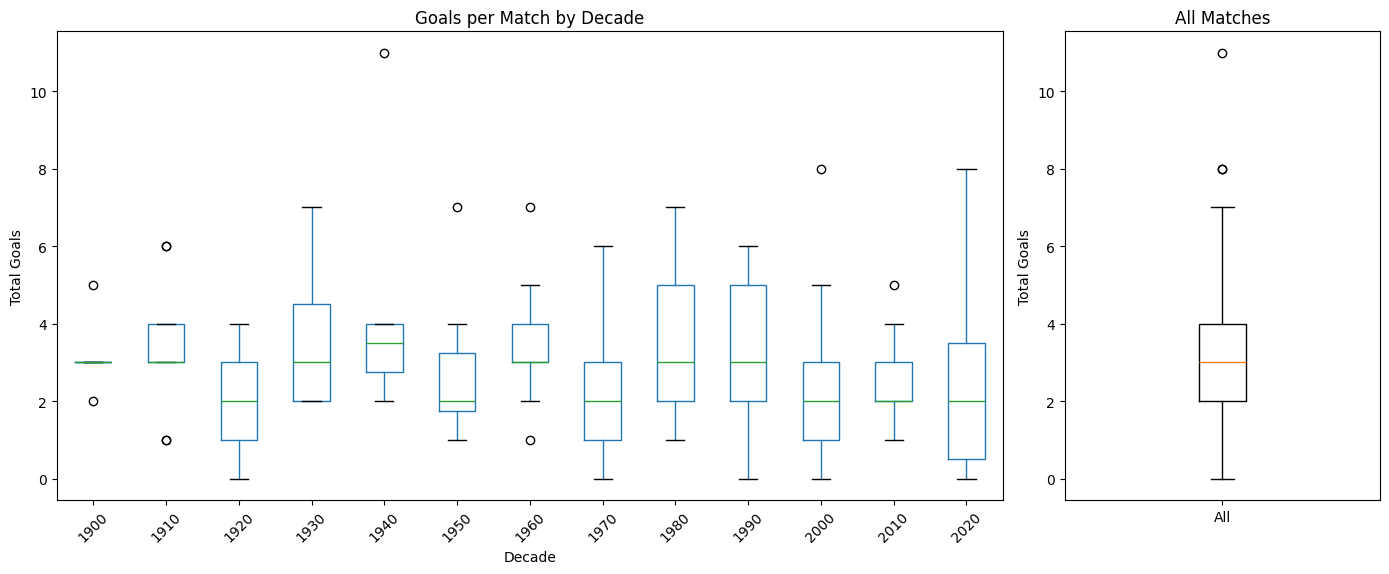

In [38]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [3, 1]})

# --- Box plot by Decade (esquerda)
df.boxplot(column="goals_total", by="Decade", grid=False, ax=axes[0])
axes[0].set_title("Goals per Match by Decade")
axes[0].set_xlabel("Decade")
axes[0].set_ylabel("Total Goals")
axes[0].tick_params(axis="x", rotation=45)

# --- Box plot global (direita)
axes[1].boxplot(df["goals_total"].dropna(), vert=True)
axes[1].set_title("All Matches")
axes[1].set_xticks([1])
axes[1].set_xticklabels(["All"])
axes[1].set_ylabel("Total Goals")

# Remove pandas auto suptitle
plt.suptitle("")
plt.tight_layout()
plt.show()

### 2.1 Interpreting the box plots 🔍📦

Each box in the plot represents the distribution of total goals **per match** within a given group 
(either a specific decade or all matches combined). The main components are:

- **Median (line inside the box):** the typical number of goals in that group.
- **Box edges (Q1 and Q3):** the 25th and 75th percentiles, showing where the middle 50% of the data lies.
- **Whiskers:** extend to the lowest and highest values that are not considered outliers.
- **Outliers (dots beyond whiskers):** unusually high- or low-scoring matches compared to the majority.

--- 

### Decade of 1900s
Few matches

### Decade of 1910s
Few matches

### Decade of 1920s
- **Median:** ~2 goals per match, most games were low scoring.
- **Interquartile range (box):** narrow, indicating consistency around 1–2 goals.
- **Whiskers:** extend up to 4 goals in a few matches.
- **Outliers:** occasional higher results, but rare in this decade.

### Decade of 1930s
- **Median:** ~2 goals per match, similar to the 1920s.
- **Interquartile range:** wider than the 1920s, showing more variability.
- **Whiskers:** several games reached 5–6 goals.
- **Outliers:** notable 6–0 in 1935 and other high-scoring matches.

### Decade of 1940s
- **Median:** ~2 goals per match, still balanced.
- **Interquartile range:** moderate, with most games between 1 and 3 goals.
- **Whiskers:** stretch to 4–5 goals.
- **Outliers:** the remarkable **7–4 in 1946** stands out strongly.

### Decade of 1950s
- **Median:** ~2 goals per match, keeping the same central tendency.
- **Interquartile range:** moderate, many games finishing 1–2 goals.
- **Whiskers:** extend to 4–5 goals.
- **Outliers:** a few 5-goal games, but not extreme compared to the 1940s.

### Decade of 1960s
- **Median:** ~2 goals per match.
- **Interquartile range:** narrow, most matches very clustered.
- **Whiskers:** extend to 4–5 goals.
- **Outliers:** rare, but still some unusually high-scoring matches.

### Decade of 1970s
- **Median:** ~2 goals per match, slightly defensive era.
- **Interquartile range:** narrow, showing low variation.
- **Whiskers:** mostly capped at 3–4 goals.
- **Outliers:** very few, confirming low-scoring consistency.

### Decade of 1980s
- **Median:** ~2 goals per match.
- **Interquartile range:** narrow, again consistent outcomes.
- **Whiskers:** stretch to 4–5 goals.
- **Outliers:** some matches with 5+ goals, but still uncommon.

### Decade of 1990s
- **Median:** ~2 goals per match, continuing the trend.
- **Interquartile range:** narrow, 1–3 goals typical.
- **Whiskers:** some games reaching 4–5 goals.
- **Outliers:** a few games with 5+ goals, but rare.

### Decade of 2000s
- **Median:** ~2 goals per match.
- **Interquartile range:** moderate, with more 2–3 goal matches.
- **Whiskers:** up to 4–5 goals.
- **Outliers:** a few thrillers, such as 4–4 in 2009.

### Decade of 2010s
- **Median:** ~2 goals per match.
- **Interquartile range:** narrow, strongly centered around 1–2 goals.
- **Whiskers:** some matches at 4–5 goals.
- **Outliers:** a few above-average results, but no extreme 7+ goal games.

### Decade of 2020s
- **Median:** ~2 goals per match so far.
- **Interquartile range:** narrow, small dataset with consistent results.
- **Whiskers:** extend to 5 goals in a few matches.
- **Outliers:** not many, but limited number of games makes conclusions tentative.

### All Matches (1907–2025)

- **Median:** ~2 goals per match, confirming that historically most encounters have been low-scoring and tight.  
- **Interquartile range (box):** concentrated between 1 and 3 goals, showing that the majority of matches stayed in this narrow band.  
- **Whiskers:** extend to 4–5 goals, indicating that games with slightly higher totals are not unusual.  
- **Outliers:** a few extreme thrillers stand out, such as **7–4 in 1946** and **4–4 in 2009**, which are rare compared to the overall pattern.  

📌 **Interpretation:** Over more than a century, Chelsea vs. Liverpool has generally been a balanced fixture, with most matches producing 2 goals.  
The box plot confirms that very high-scoring encounters are exceptions rather than the rule.